# Note!
This is a almost cell-by-cell copy of the work done by Aaron Schlegel. I practically don't own any of the work here.
See the original posts here:

[Part 1: Extraction and Feature Engineering](https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html)

[Part 2: Exploratory Data Analysis](https://aaronschlegel.me/exploratory-data-analysis-shelter-cat-outcomes-pandas-seaborn.html)

[Part 3: Machine Learning for Outcome Prediction](https://aaronschlegel.me/predict-shelter-cat-outcomes-scikit-learn-machine-learning.html)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import re
from datetime import datetime, timedelta

In [2]:
df = pd.read_csv('aac_shelter_outcomes.csv', parse_dates=['date_of_birth','datetime','monthyear'])
cats_df = df[df.animal_type == 'Cat']
cats_df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,2014-07-22 16:04:00,NaN,Partner,Transfer,Intact Male
8,1 month,A685067,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16,2014-08-14 18:45:00,2014-08-14 18:45:00,Lucy,NaN,Adoption,Intact Female
9,3 months,A678580,Cat,Domestic Shorthair Mix,White/Black,2014-03-26,2014-06-29 17:45:00,2014-06-29 17:45:00,*Frida,Offsite,Adoption,Spayed Female
10,1 year,A675405,Cat,Domestic Medium Hair Mix,Black/White,2013-03-27,2014-03-28 14:55:00,2014-03-28 14:55:00,Stella Luna,NaN,Return to Owner,Spayed Female
17,3 weeks,A670420,Cat,Domestic Shorthair Mix,Black/White,2013-12-16,2014-01-09 19:29:00,2014-01-09 19:29:00,NaN,Partner,Transfer,Intact Male


<ipython-input-3-b1975d747add>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_df['age'] = (cats_df.datetime - cats_df.date_of_birth).dt.days


<AxesSubplot:>

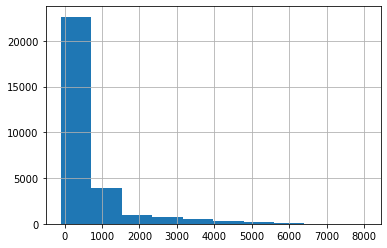

In [3]:
cats_df['age'] = (cats_df.datetime - cats_df.date_of_birth).dt.days
cats_df.age.hist()

In [4]:
cats_df['kitten'] = cats_df.age <= 180


<ipython-input-4-b64afa8822ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_df['kitten'] = cats_df.age <= 180


In [5]:
cats_df.outcome_type.value_counts(dropna=False)

Transfer           13323
Adoption           12732
Euthanasia          1453
Return to Owner     1431
Died                 403
Rto-Adopt             33
Missing               28
Disposal              16
NaN                    3
Name: outcome_type, dtype: int64

In [6]:
cats_df['dob_year'] = cats_df['date_of_birth'].dt.year
cats_df['dob_month'] = cats_df['date_of_birth'].dt.month
cats_df['dob_monthyear'] = pd.to_datetime(
    cats_df['monthyear']).dt.to_period('M')

cats_df['outcome_month'] = cats_df['datetime'].dt.month
cats_df['outcome_year'] = cats_df['datetime'].dt.year
cats_df['outcome_weekday'] = cats_df['datetime'].dt.weekday
cats_df['outcome_hour'] = cats_df['datetime'].dt.hour


<ipython-input-6-d261f503b523>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_df['dob_year'] = cats_df['date_of_birth'].dt.year
<ipython-input-6-d261f503b523>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_df['dob_month'] = cats_df['date_of_birth'].dt.month
<ipython-input-6-d261f503b523>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [7]:
cats_df['breed'].value_counts()

Domestic Shorthair Mix                 23335
Domestic Medium Hair Mix                2323
Domestic Longhair Mix                   1228
Siamese Mix                              998
Domestic Shorthair                       386
                                       ...  
Domestic Shorthair/Manx                    1
Ocicat Mix                                 1
Manx/Siamese                               1
Domestic Longhair/Domestic Longhair        1
Domestic Shorthair/Abyssinian              1
Name: breed, Length: 79, dtype: int64

In [8]:
cats_df['breed'] = cats_df['breed'].str.lower().str.replace(
    'mix', '').str.replace('medium hair', 'mediumhair').str.strip()

<ipython-input-8-843f71dc0208>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_df['breed'] = cats_df['breed'].str.lower().str.replace(


In [9]:
cfa_breeds = ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair',
              'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Burmilla',
              'Chartreux', 'Colorpoint Shorthair', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'European Burmese',
              'Exotic', 'Havana Brown', 'Japanese Bobtail', 'Korat', 'LaPerm', 'Maine Coon', 'Manx',
              'Norwegian Forest Cat', 'Ocicat', 'Oriental', 'Persian', 'Ragamuffin', 'Ragdoll', 'Russian Blue',
              'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Somali', 'Tonkinese',
              'Turkish Angora', 'Turkish Van']

cfa_breeds = [i.lower() for i in cfa_breeds]
cfa_breeds = '|'.join(cfa_breeds)

In [11]:
new_cols = cats_df['breed'].str.split('/', expand=True).rename(columns={0: 'breed1', 1: 'breed2'})
cats_df['breed1'] = new_cols['breed1']
cats_df['breed2'] = new_cols['breed2']

cats_df['cfa_breed'] = (cats_df['breed1'].str.contains(cfa_breeds)) | \
                        (cats_df['breed2'].str.contains(cfa_breeds))

cats_df['domestic_breed'] = (cats_df['breed1'].str.contains('domestic')) | \
                             (cats_df['breed2'].str.contains('domestic'))

<ipython-input-11-57c5bbcfe516>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_df['breed1'] = new_cols['breed1']
<ipython-input-11-57c5bbcfe516>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_df['breed2'] = new_cols['breed2']
<ipython-input-11-57c5bbcfe516>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [12]:
cats_df['color'].value_counts()

Brown Tabby                 4445
Black                       3847
Black/White                 2804
Brown Tabby/White           2338
Orange Tabby                2180
                            ... 
Brown Tabby/Orange Tabby       1
Black Tiger/White              1
Brown Tabby/Gray Tabby         1
Orange Tabby/Apricot           1
Blue Point/Cream               1
Name: color, Length: 231, dtype: int64

In [13]:
coat_patterns = ['tabby', 'tortie', 'tortoiseshell', 'calico', 'smoke', 'torbie',
                 'colorpoint', 'point', 'brindle', 'agouti', 'bicolor', 'tricolor']
coat_reg = '(' + '|'.join(coat_patterns) + ')'
cats_df['color'] = cats_df['color'].str.lower()
cats_df['coat_pattern'] = cats_df['color'].str.extract(coat_reg, expand=False)
cats_df['color'] = cats_df['color'].str.replace(coat_reg, '').str.strip()

<ipython-input-13-74aac3314909>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_df['color'] = cats_df['color'].str.lower()
<ipython-input-13-74aac3314909>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_df['coat_pattern'] = cats_df['color'].str.extract(coat_reg, expand=False)
<ipython-input-13-74aac3314909>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [14]:
new_cols = cats_df['color'].str.split(
    '/', expand=True).rename(columns={0: 'color1', 1: 'color2'})
cats_df['color1'] = new_cols['color1']
cats_df['color2'] = new_cols['color2']

cats_df = pd.concat([cats_df,
                     ], axis=1)
cats_df['color1'] = np.where(
    cats_df['color1'] == '', 'Breed Specific', cats_df['color1'])
cats_df['coat'] = np.where(
    cats_df['color1'] == 'Breed Specific', cats_df['coat_pattern'], cats_df['color1'])


<ipython-input-14-2c29f2dcb4a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_df['color1'] = new_cols['color1']
<ipython-input-14-2c29f2dcb4a2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_df['color2'] = new_cols['color2']


In [15]:
cats_df.to_csv('cats_df_clean.csv', index=False, encoding='utf-8')